# Basic Text Classification with Naive Bayes

In the mini-project, I used a fundamental technique in Bayesian inference, called Naive Bayesthe, and basics of text analysis to perform analysis on a subset of movie reviews from the rotten tomatoes database.
***

In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Rotten Tomatoes Dataset

In [7]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [8]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


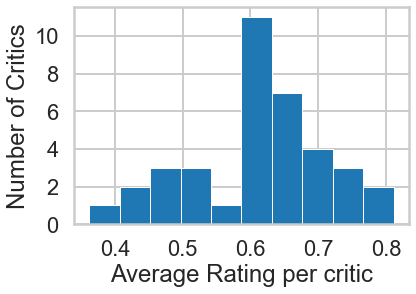

In [9]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

**Interpretation of the Histogram above:**<br>
For movies that received over 100 reviews, a majority of reviewers generally liked the movies (average rating > 0.5) they reviewed. The mode of the rating is around 0.6 and the shape of the distribution almost similar to a normal distribution, however it looks more like a bimodal, with the first peak at 0.5 and the second peak at 0.65. 

## The Vector Space Model and a Search Engine

### In Code

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [11]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, **the probability that a document (or whatever is being classified) belongs to a category given the features in the document.**

Since I am modeling word counts, I will use a variation of Naive Bayes called **Multinomial Naive Bayes.** This is because the likelihood function actually takes the form of the multinomial distribution.

There are many other variations of Naive Bayes, all which depend on what type of values.

Below I attempted to implement a simple Naive Bayes classifier through the following steps:

1. split the data set into a training and test set
2. Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
3. train the classifier over the training set and test on the test set
4. print the accuracy scores for both the training and the test sets

In [12]:
# Import Stage
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20)

# Use classifier with default parameters 
classi = MultinomialNB()  # Use default parameters

# Train Classifier on training set
classi.fit(X_train, y_train)

# Accuracy Scores: 
train_a_score = classi.score(X_train, y_train)
test_a_score = classi.score(X_test, y_test)

print("Accuracy score for the training set: {:0.3f}".format(train_a_score))
print("Accuracy score for the test set: {:0.3f}".format(test_a_score))

Accuracy score for the training set: 0.920
Accuracy score for the test set: 0.786


**Interpretation:** <br>
As can be seen from the results of accuracy scores, this model doesn't do well on the test set (lower accuracy score). This implies that the model is overfitting to the training set and is not generalizable to new, unseen data. In conclusion, it is not a good classifier.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

I need to know what value to use for $\alpha$, and which words to include in the vocabulary:

First, find an appropriate value for `min_df` for the `CountVectorizer`. <br>

`min_df` can be either an integer or a float. <br>

If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary.<br> 

If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary.

Sources: [A Gentle Introduction to Sparse Matrices for Machine Learning](https://machinelearningmastery.com/sparse-matrices-for-machine-learning/)

In [13]:
# Define cdf function (from Datacamp modules)

def ecdf(data):
    """Compute ECDF for a 1-D array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x_cdf = np.sort(data)

    # y-data for the ECDF: y
    y_cdf = np.arange(1, n+1) / n

    return x_cdf, y_cdf

In [14]:
# Originally X is a sparse matrix with a shape of <15561 x 22417>
# 15561 --> # of documents
# 22417 --> # of words / features
X.shape

# Converting back to a numpy array
np_X_array = X.toarray()

# Sanity check for the shape after conversion
np_X_array.shape

(15561, 22417)

The rows of the sparse matrix represent a unique document and the columns represent the features/words in the lexicon. Every document in the corpus will account for every word found in the corpus (collection of documents), since the dictionary of the vocabulary (lexicon) is created from this corpus.

To calculate the number of total word counts for each document, I need to perform a summation (reduction) process across the rows, which would output a single column with the total word count per document (per row). <br>

To make this easier, I will convert the sparse matrix into a pandas dataframe:

In [15]:
# Making a dataframe
word_df = pd.DataFrame(np_X_array)

# Summation across the rows
summation = word_df.sum(axis=0)

In [16]:
# Sanity Check  
summation.head()
summation.shape

(22417,)

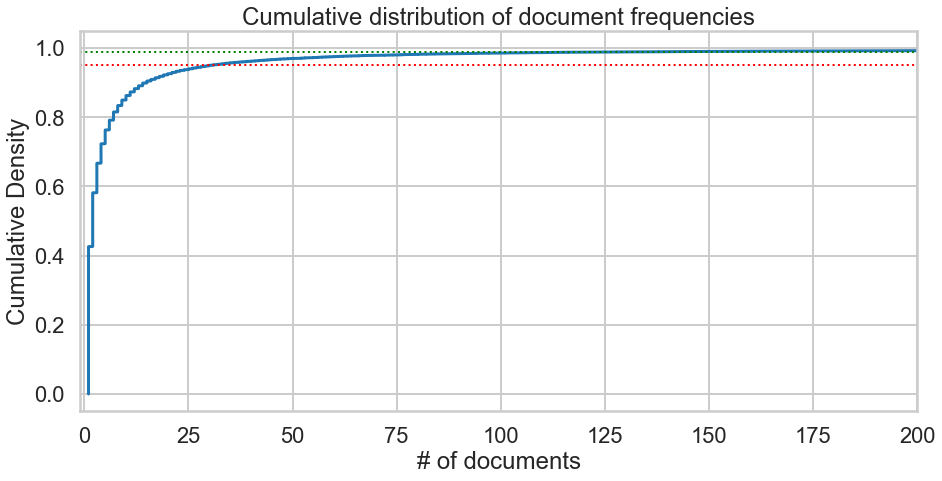

In [17]:
# Plotting the CDF:
x_document, y_cdf = ecdf(summation)
plt.figure(figsize = (15,7))
plt.plot(x_document, y_cdf, ms=5)
plt.axhline(0.95, c='red', linestyle=':', linewidth=2)  # 95% mark
plt.axhline(0.99, c='green', linestyle=':', linewidth=2)  # 95% mark
plt.xlabel("# of documents")
plt.ylabel("Cumulative Density")
plt.title("Cumulative distribution of document frequencies")
plt.xlim(-1, 200)  # Limit the x-axis since # of documents is too large! 
plt.show()

**Result:** The red horizontal line above shows the 95% mark. This shows that about 30 documents account for up 95% of the words in the entire lexicon dictionary. The curve climbs steeply from the start, thus effectively set min_df to be 1.

For max_df, we can observe that the curve starts to plateau at the 99% mark. That corresponds to about 100 documents. Therefore, 100 can be the max_df.

Next:

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but K-fold cross validation will be used. In K-fold cross-validation, the data divides into $K$ non-overlapping parts. Train on $K-1$ of the folds and test on the remaining fold; then iterate so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm, however, on order ot measure the performance of the algorithm on each fold, I will need to pass a function. 

In [18]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

The log-likelihood was used as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, the `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows the use different metrics depending on the decision risk (i.e: precision, accuracy, profit etc.) directly on the validation set. Most people oftenly use `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [19]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

Cross-validate over the regularization parameter $\alpha$.

Setting up the train and test masks first, and then run the cross-validation procedure:

In [20]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

### Commentary: 

* Using log-likelihood <br>

The log-probability is used for estimation because probabilities can become very small and logarithm calculations allow us to scale up/down values without losing out information ([Why use log-probability estimates in GaussianNB [scikit-learn]?](https://stackoverflow.com/questions/20335944/why-use-log-probability-estimates-in-gaussiannb-scikit-learn)). <br>

Additionally, another use-case for log-probability estimates is to multiply probabilties since we may at some point run into floating point precision issues. To get around this, we can use the sum of logarithms ([sklearn - Why predict_log_proba()?](https://www.reddit.com/r/MLQuestions/comments/5lzv9o/sklearn_why_predict_log_proba/)).

* Choosing High $\alpha$ values <br>

Alpha is the Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing). The concept of $\alpha$ is to decrease the effect of rare words. Higher $\alpha$ will suppress the effect of rare words more than a lower $\alpha$ ([Scikit : How to choose alpha of multinomailNB](https://stackoverflow.com/questions/30498021/scikit-how-to-choose-alpha-of-multinomailnb)).

***
Finding the best values of the parameter `alpha`, and use the value of `min_df` chosen previously and using the `cv_score` function above with the `log_likelihood` function for scoring:

In [25]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 1

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    
    clf_cv = MultinomialNB(alpha=alpha)   # iteration through [alphas]
    score = cv_score(clf_cv, Xtrainthis, ytrainthis, log_likelihood)

if score > maxscore:
    maxscore = score
    best_alpha = alpha
        
print("Best alpha value: {}".format(best_alpha))
print("Chosen min_df value: {}".format(best_min_df))
print("Maximum score for the training set with given alpha: {}".format(maxscore))

Best alpha value: 50
Chosen min_df value: 1
Maximum score for the training set with given alpha: -1397.6805459625702


In [26]:
print("alpha: {}".format(best_alpha))

alpha: 50


Using the best value of  `alpha` just found to calculate the accuracy on the training and test sets:

In [27]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.604840
Accuracy on test data:     0.612009


In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[   4 4225]
 [   1 6662]]


Accuracy on training data is 0.60 and the accuracy on test data is 0.61. Previously without hyperparameter tuning, the scores for training data and test data respectively were 0.920 and 0.786. The scores has decreased significantly. We conclude that this is not a better classifier.

## Interpretation

### What are the strongly predictive features?

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [29]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1]) 
# xtest.shape[1] --> returns the size of column (features)
# np.eye(n) --> returns identity matrix of size n
# Thus, returns an identity matrix of size (xtest column (feature) shape)
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
                most 0.79
                best 0.76
        entertaining 0.75
                  of 0.74
                 his 0.74
                 and 0.74
               still 0.74
                film 0.73
       entertainment 0.73
               great 0.73
Bad words	     P(fresh | word)
                want 0.55
       unfortunately 0.54
             problem 0.54
               wrong 0.54
                dull 0.54
                 isn 0.53
               fails 0.53
              really 0.52
                 bad 0.51
                 too 0.49


**Interpretation:** <br>
The probability represents the probability of a review being fresh/rotten given one word. Basically, we're using an wisdom of the masses approach - ie. certain words associated with a fresh/rotten review get higher/lower probabilities respectively. This method works because there is a lot of observations (rows) in the dataset.

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [30]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
These are the same performers who appear on the TV show, and you get the feeling this has become more than a meal ticket for them. Hokey dialogue is invested with an intensity that takes you out of the movie and into the psyches of the actors.

All of the special effects in the world, and all of the great makeup, and all of the great Muppet creatures can't save a movie that has no clear idea of its own mission and no joy in its own accomplishment.

Capra is an old-time movie craftsman, the master of every trick in the bag, and in many ways he is more at home with the medium than any other Hollywood director. But all of his details give the impression of contrived effect.

Cast of newcomers is appealing, but this small-town melodrama is so old-fashioned and out-of-touch with contemporary youth that it feels as if it were made the same time that its story is set, in 1957.

I liked a lot of the movie, which is genial and has a lot of

Using the best trained classifier to predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*:

In [33]:
test_quote = ['This movie is not remarkable, touching, or superb in any way']

quote = vectorizer.transform(test_quote)

predict_class = clf.predict(quote)
predict_proba = clf.predict_proba(quote)[:,1][0]

print("The optimized model predicts the given quote as {}, (fresh = 1 / rotten = 0) with a probability of: {:0.3f}".format(predict_class, predict_proba))


The optimized model predicts the given quote as [1], (fresh = 1 / rotten = 0) with a probability of: 0.965


The model misclassifies the quote because the model does not know the semantics of any word. For example, the machine does not know that not acts as a negator for the entire sentence. Simple frequency counting will not be able to capture the concept of negation.

### Aside note: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, I used just the term frequency in a document of words. In TF-IDF, this term frequency is weighted by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, it becomes downweighted. Then the use of this TF-IDF weighted features inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks. 

In [34]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [35]:
Xtfidf

<15561x22125 sparse matrix of type '<class 'numpy.float64'>'
	with 156947 stored elements in Compressed Sparse Row format>

# End of Notebook